<a href="https://colab.research.google.com/github/danielpark98/CorpFinance_WRDS_Python/blob/main/Illiquidity_Measure_Using_CRSP_0509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import datetime
from pathlib import Path

db=wrds.Connection()
crsp_0509= db.raw_sql("SELECT * FROM crsp.dsf WHERE date>='2005-01-01' AND date <='2009-12-31'")
db.close()
crsp_0509

data = crsp_0509
data['date'] = pd.to_datetime(data['date'])
data.head()

# Adjust prices and shares
data['prc_adj'] = abs(data['prc']) / data['cfacpr']
data['shrout_adj'] = data['shrout'] * data['cfacshr']

# Set date as index for interpolation
data.set_index('date', inplace=True)

# Replace zero values with NaN for interpolation
data[['vol', 'prc_adj', 'askhi', 'bidlo', 'ask', 'bid', 'openprc']] = data[['vol', 'prc_adj', 'askhi', 'bidlo', 'ask', 'bid', 'openprc']].replace(0, np.nan)

# Interpolate missing and zero values
data[['vol', 'prc_adj', 'askhi', 'bidlo', 'ask', 'bid', 'openprc']] = data.groupby('permno')[['vol', 'prc_adj', 'askhi', 'bidlo', 'ask', 'bid', 'openprc']].transform(lambda group: group.interpolate(method='linear'))

# Reset index for groupby operation
data.reset_index(inplace=True)

# Group by 'permno' and 'date' (to monthly)
grouped = data.groupby([data['permno'], data['date'].dt.to_period('M')])

# Calculate monthly volume
monthly_volume = grouped['vol'].sum()

# Calculate shares outstanding
shares_outstanding_adj = grouped['shrout'].mean()

# Calculate turnover with adjusted shares
monthly_data = pd.DataFrame(monthly_volume / shares_outstanding_adj, columns=['turnover'])

# Calculate other measures
monthly_data['daily_spread_highlow'] = grouped.apply(lambda x: np.mean(x['askhi'] - x['bidlo'])).values
monthly_data['daily_spread_closing'] = grouped.apply(lambda x: np.mean(x['ask'] - x['bid'])).values

# Calculate the HL_Spread measure
def calculate_hl_spread(group):
    beta = (np.log(group['askhi'] / group['bidlo']) ** 2).mean()
    gamma = (np.log(group['askhi'].max() / group['bidlo'].min()) ** 2)
    alpha = (np.sqrt(2*beta) - np.sqrt(beta)) / (3 - 2*np.sqrt(2)) - np.sqrt(gamma / (3 - 2*np.sqrt(2)))
    spread = 2*(np.exp(alpha) - 1) / (1 + np.exp(alpha))
    return spread

monthly_data['HL_spread'] = grouped.apply(calculate_hl_spread).values
monthly_data['HL_spread'] = abs(monthly_data['HL_spread'] / 10)

# Calculate Roll measure
def calculate_roll(group):
    price_changes = np.log(group['prc_adj']).diff()
    cov = price_changes.cov(price_changes.shift())
    return 2 * np.sqrt(-cov) if cov < 0 else 0

monthly_data['roll'] = grouped.apply(calculate_roll).values
# Calculate Amihud measure
def calculate_amihud(group):
    dollar_volume = (group['prc_adj'] * group['vol']) / 1_000_000
    return (group['ret'].abs() / dollar_volume).mean()

monthly_data['amihud'] = grouped.apply(calculate_amihud).values
# Calculate Realized_Volatility
monthly_data['realized_volatility'] = grouped.apply(lambda x: np.sum(x['ret'] ** 2)).values
# Calculate Return_STD
monthly_data['return_std'] = grouped['ret'].std().values
monthly_data = monthly_data.reset_index()
monthly_data.to_csv("/content/drive/MyDrive/crsp_0509.csv", index=False)
monthly_data

Enter your WRDS username [root]:danielpark98
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1609: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b, ddof=ddof)[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,permno,date,turnover,daily_spread_highlow,daily_spread_closing,HL_spread,roll,amihud,realized_volatility,return_std
0,10001.0,2005-01,19.831690,0.194500,0.150500,9.636635e-03,0.035363,3.430440,0.013168,0.026265
1,10001.0,2005-02,29.405669,0.310737,0.188421,1.880566e-02,0.015114,4.215188,0.014370,0.028176
2,10001.0,2005-03,157.935494,0.372455,0.154545,5.275877e-02,0.054619,2.737128,0.059080,0.052604
3,10001.0,2005-04,21.423619,0.227143,0.259524,2.704549e-02,0.042791,3.250118,0.020363,0.031739
4,10001.0,2005-05,75.793143,0.400186,0.203809,6.119479e-02,0.041954,2.259737,0.040679,0.043843
...,...,...,...,...,...,...,...,...,...,...
418140,93191.0,2009-12,92.789554,0.873300,0.080000,3.233171e-02,0.000000,0.001162,0.015787,0.053212
418141,93192.0,2009-12,15.593246,0.310990,0.065000,2.596040e-02,0.000000,0.158438,0.009584,0.034474
418142,93193.0,2009-12,723.293131,0.461633,0.128000,5.134547e-02,0.000000,0.131809,0.016068,0.034502
418143,93194.0,2009-12,0.000000,475.000000,475.000000,5.329071e-16,0.000000,NaN,0.000000,NaN


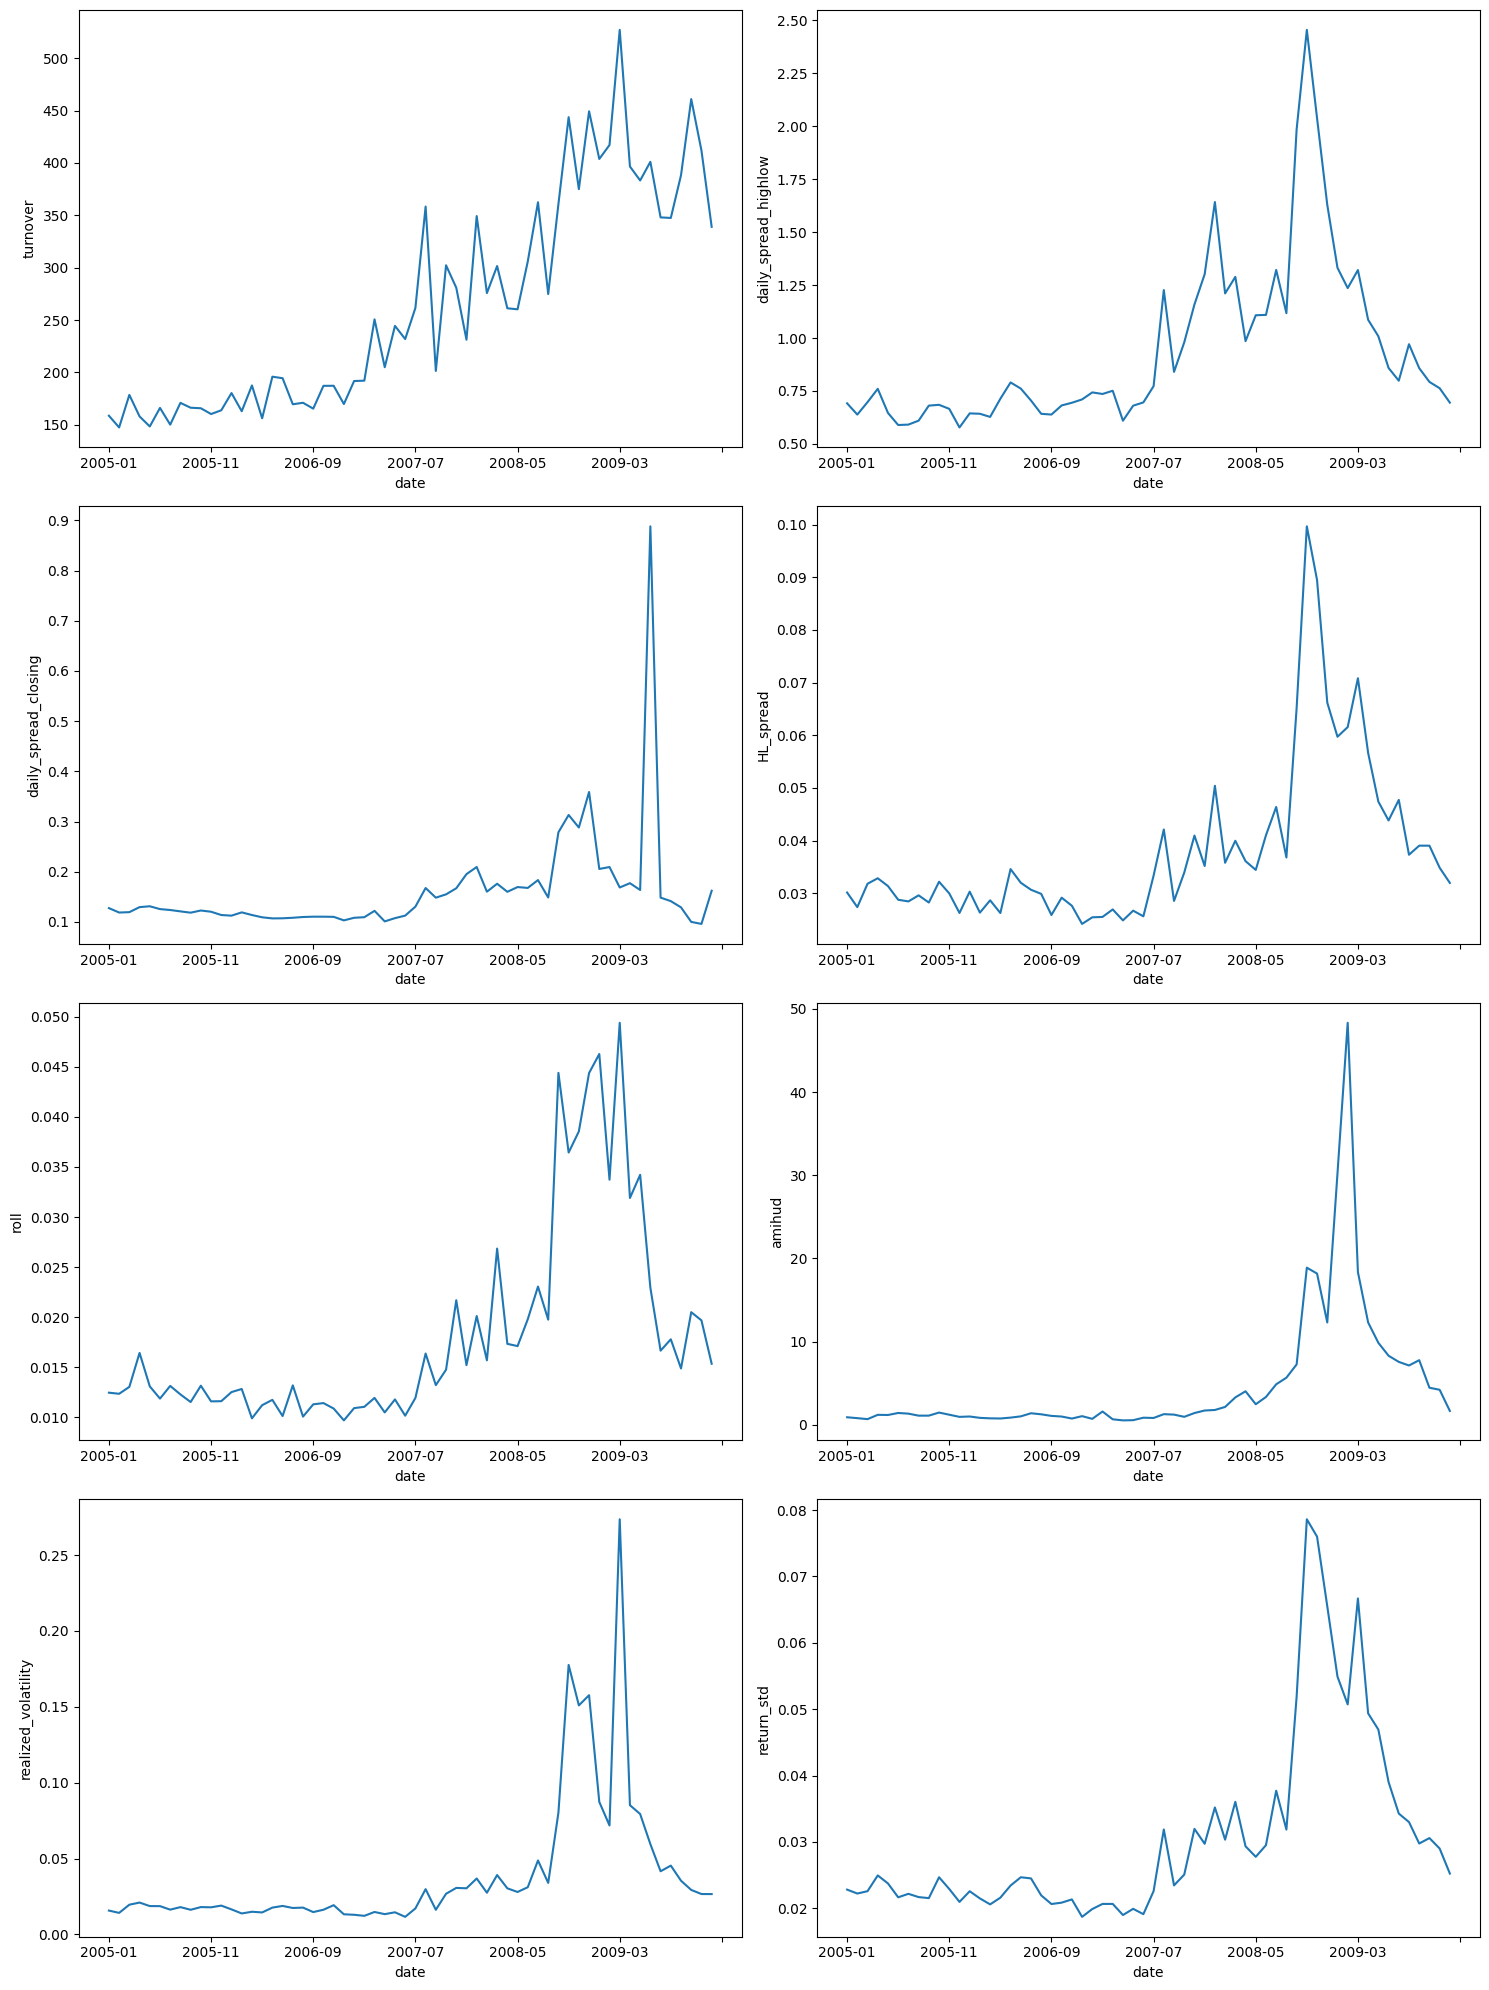

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
df_new = pd.read_csv("/content/drive/MyDrive/crsp_0509.csv")
# Set the figure size
plt.figure(figsize=(15, 20))

# Create a separate line plot for each measure
for i, column in enumerate(df_new.drop(['permno', 'date'], axis=1).columns, start=1):
    plt.subplot(4, 2, i)
    df_new.groupby('date')[column].mean().plot()
    plt.ylabel(column)

# Adjust the layout for better visualization
plt.tight_layout()
plt.show()
